In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""


"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [19]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## About Dataset
There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
- Task: Automated methods to detect and classify human diseases from medical images.

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Dropout,Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception, xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.activations import softmax, sigmoid, relu
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score, precision_score

import itertools
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
BASE_PATH = "../input/chest-xray-pneumonia/chest_xray/chest_xray/"
NUM_CLASSES = 1
CHANNELS = 3
IMAGE_RESIZE = 224
NUM_EPOCHS = 100
EARLY_STOP_PATIENCE = 10

BATCH_SIZE_TRAINING = 32
BATCH_SIZE_VALIDATION = 32

In [5]:
for folder in os.listdir(BASE_PATH + "train"):
    try:
        print(str(len(os.listdir(BASE_PATH + "train/" + folder))) + " " + folder + " images")
    except:
        print('not a folder')

not a folder
1342 NORMAL images
3876 PNEUMONIA images


------------
# Transfer Learning with Xception

In [6]:
model = Sequential()
model.add(Xception(include_top=False, weights='imagenet', input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, CHANNELS), pooling='avg'))
model.add(Dropout(0.7))
model.add(Dense(1024, activation=relu))
model.add(Dropout(0.7))
model.add(Dense(512, activation=relu))
model.add(Dropout(0.7))
model.add(Dense(NUM_CLASSES, activation=sigmoid))
model.layers[0].trainable = False
model.summary()

83689472/83683744 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________

In [7]:
model.compile(loss=BinaryCrossentropy(), 
              optimizer=tf.keras.optimizers.SGD(0.1, momentum=0.9, nesterov=True, decay=0.01), #decay=0.01
              #optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

In [8]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max', restore_best_weights=True, patience=EARLY_STOP_PATIENCE),
    ModelCheckpoint(filepath='../working/pneumonia_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)
]

In [9]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,
    #validation_split=0.2
)

In [10]:
train_data_gen = data_generator.flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/',
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE),
    batch_size=BATCH_SIZE_TRAINING,
    class_mode='binary',
    shuffle=True,
    seed=0,
    #subset="training" #constant string
)

valid_data_gen = data_generator.flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/chest_xray/val/',
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE),
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode='binary',
    shuffle=True,
    seed=0,
    #subset="validation" #constant string
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [11]:
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=train_data_gen.samples//BATCH_SIZE_TRAINING,
                              validation_data=valid_data_gen,
                              validation_steps=valid_data_gen.samples//BATCH_SIZE_VALIDATION,
                              epochs=NUM_EPOCHS,
                              callbacks = callbacks
                             )

Train for 163 steps, validate for 1 steps
Epoch 1/100
163/163 [==============================] - 209s 1s/step - loss: 0.8063 - accuracy: 0.7429 - val_loss: 1.3011 - val_accuracy: 0.5000
Epoch 2/100
163/163 [==============================] - 191s 1s/step - loss: 0.4167 - accuracy: 0.8046 - val_loss: 0.4650 - val_accuracy: 0.8125
Epoch 3/100
163/163 [==============================] - 191s 1s/step - loss: 0.3534 - accuracy: 0.8407 - val_loss: 0.4849 - val_accuracy: 0.6875
Epoch 4/100
163/163 [==============================] - 190s 1s/step - loss: 0.3463 - accuracy: 0.8493 - val_loss: 0.4181 - val_accuracy: 0.7500
Epoch 5/100
163/163 [==============================] - 186s 1s/step - loss: 0.3216 - accuracy: 0.8579 - val_loss: 0.4604 - val_accuracy: 0.6250
Epoch 6/100
163/163 [==============================] - 186s 1s/step - loss: 0.3136 - accuracy: 0.8650 - val_loss: 0.6017 - val_accuracy: 0.7500
Epoch 7/100
163/163 [==============================] - 185s 1s/step - loss: 0.3086 - accuracy:

------------------------------------------
# Retrain the whole network with smaller learning rate

In [12]:
model.layers[0].trainable = True

In [13]:
model.compile(loss=BinaryCrossentropy(),  
              optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001, nesterov=True),
              #optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

In [14]:
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=train_data_gen.samples//BATCH_SIZE_TRAINING,
                              validation_data=valid_data_gen,
                              validation_steps=valid_data_gen.samples//BATCH_SIZE_VALIDATION,
                              epochs=NUM_EPOCHS,
                              callbacks = callbacks
                             )

Train for 163 steps, validate for 1 steps
Epoch 1/100
163/163 [==============================] - 206s 1s/step - loss: 0.2127 - accuracy: 0.9099 - val_loss: 1.9120 - val_accuracy: 0.6250
Epoch 2/100
163/163 [==============================] - 202s 1s/step - loss: 0.1244 - accuracy: 0.9565 - val_loss: 0.6252 - val_accuracy: 0.6875
Epoch 3/100
163/163 [==============================] - 204s 1s/step - loss: 0.0898 - accuracy: 0.9676 - val_loss: 0.4015 - val_accuracy: 0.7500
Epoch 4/100
163/163 [==============================] - 202s 1s/step - loss: 0.0815 - accuracy: 0.9720 - val_loss: 0.1728 - val_accuracy: 0.9375
Epoch 5/100
163/163 [==============================] - 203s 1s/step - loss: 0.0574 - accuracy: 0.9803 - val_loss: 0.0862 - val_accuracy: 0.9375
Epoch 6/100
163/163 [==============================] - 203s 1s/step - loss: 0.0533 - accuracy: 0.9797 - val_loss: 0.9377 - val_accuracy: 0.8125
Epoch 7/100
163/163 [==============================] - 202s 1s/step - loss: 0.0531 - accuracy:

-----------------------
# Save Model using json

In [15]:
# serialize model structure to JSON    
model_json = model.to_json()
with open("pneumonia_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("pneumonia_model_w.h5")
print("Saved model to disk")

Saved model to disk


---------------------------------------------------
# Performance Metrics for validation data
## Loss/Accuracy plot

Saving figure loss_accuracy_plot


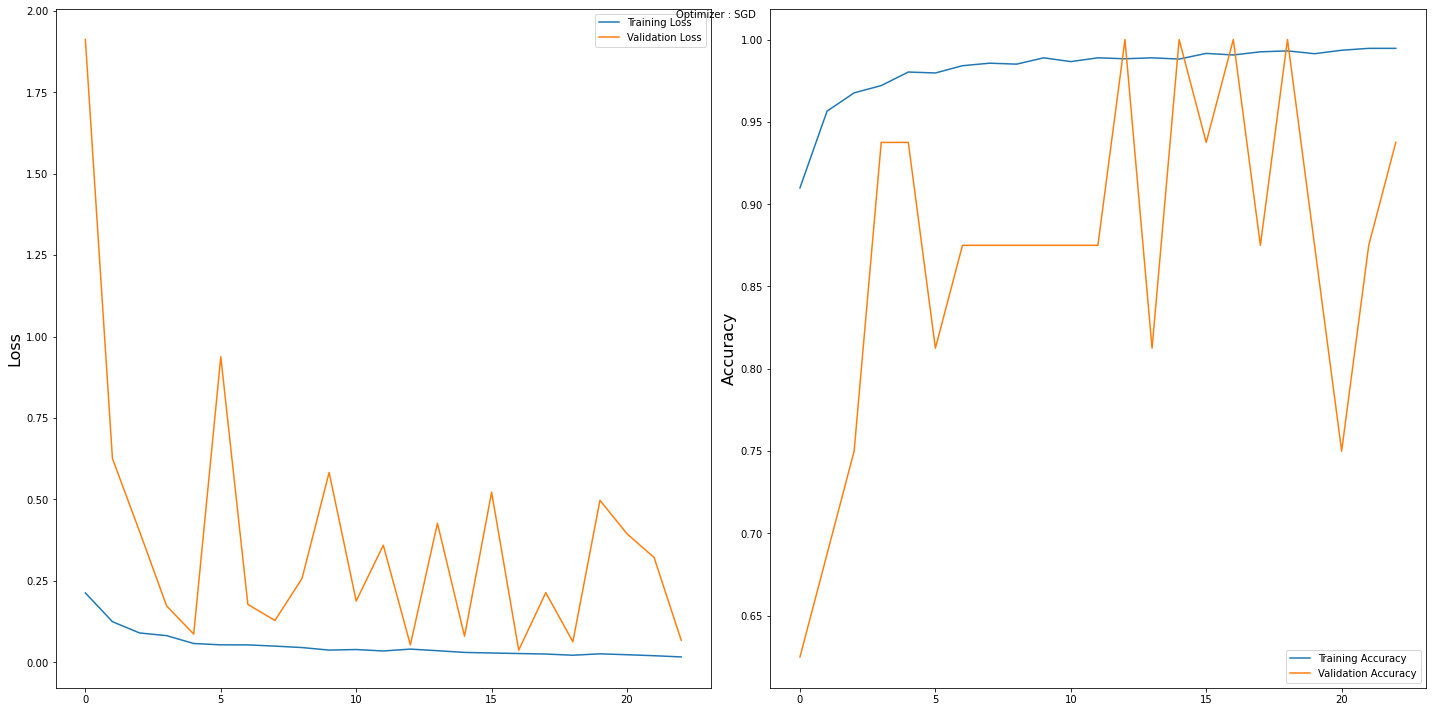

In [20]:
# plot the evolution of Loss and Acuracy on the train and validation sets
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : SGD', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

save_fig("loss_accuracy_plot")
plt.show()

## Confusion Matrix on validation data

In [21]:
# show the confusion matrix of our predictions
# compute predictions
predictions = model.predict_generator(generator=valid_data_gen)
ypred_val = [np.argmax(probas) for probas in predictions]
yvalid = valid_data_gen.classes
class_names = valid_data_gen.class_indices.keys()

In [22]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<Figure size 432x288 with 0 Axes>

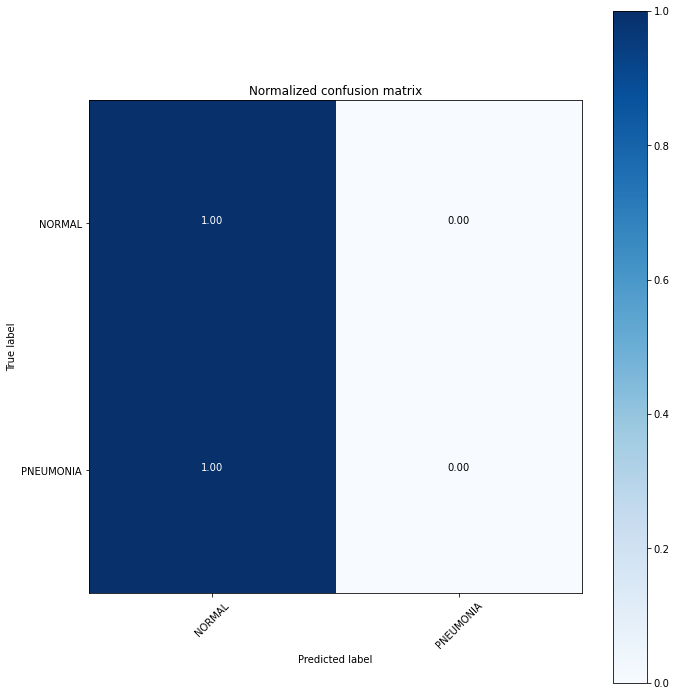

In [23]:
# compute confusion matrix
cnf_matrix = confusion_matrix(yvalid, ypred_val)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

## Recall, Precision, F1 scores

In [25]:
print("Recall score: "+str(recall_score(yvalid, ypred_val)))
print("Precision score: "+str(precision_score(yvalid, ypred_val)))
print("F1 score: "+str(f1_score(yvalid, ypred_val)))

Recall score: 0.0
Precision score: 0.0
F1 score: 0.0


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------
# Testing Phase
## Load saved model  

In [26]:
json_file = open('../working/pneumonia_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("../working/pneumonia_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
model.summary()
model.layers[0].input_shape

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

(None, 224, 224, 3)

## Load Test Data

In [29]:
batch_holder = np.zeros((624, IMAGE_RESIZE, IMAGE_RESIZE, 3))

for folder in os.listdir(BASE_PATH + "test"):
    try:
        print(str(len(os.listdir(BASE_PATH + "test/" + folder))) + " " + folder + " images")
        img_dir=BASE_PATH+'test/'+folder
        print(img_dir)
        for i,img in enumerate(os.listdir(img_dir)):
            img_path = os.path.join(img_dir,img)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMAGE_RESIZE,IMAGE_RESIZE))
            img = preprocess_input(img)
            if folder=='NORMAL':
                batch_holder[i, :] = img
            else:
                batch_holder[i+234, :] = img
    except NotADirectoryError:
        print('not a folder')

not a folder
234 NORMAL images
../input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL
390 PNEUMONIA images
../input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA


## Predict for test data

In [30]:
result=model.predict_classes(batch_holder)

In [31]:
ypred_test =[]
for i in range(result.shape[0]):
    ypred_test.append(result[i][0])

In [32]:
ytest = []
for i in range(234):
    ytest.append(0)
for i in range(390):
    ytest.append(1)

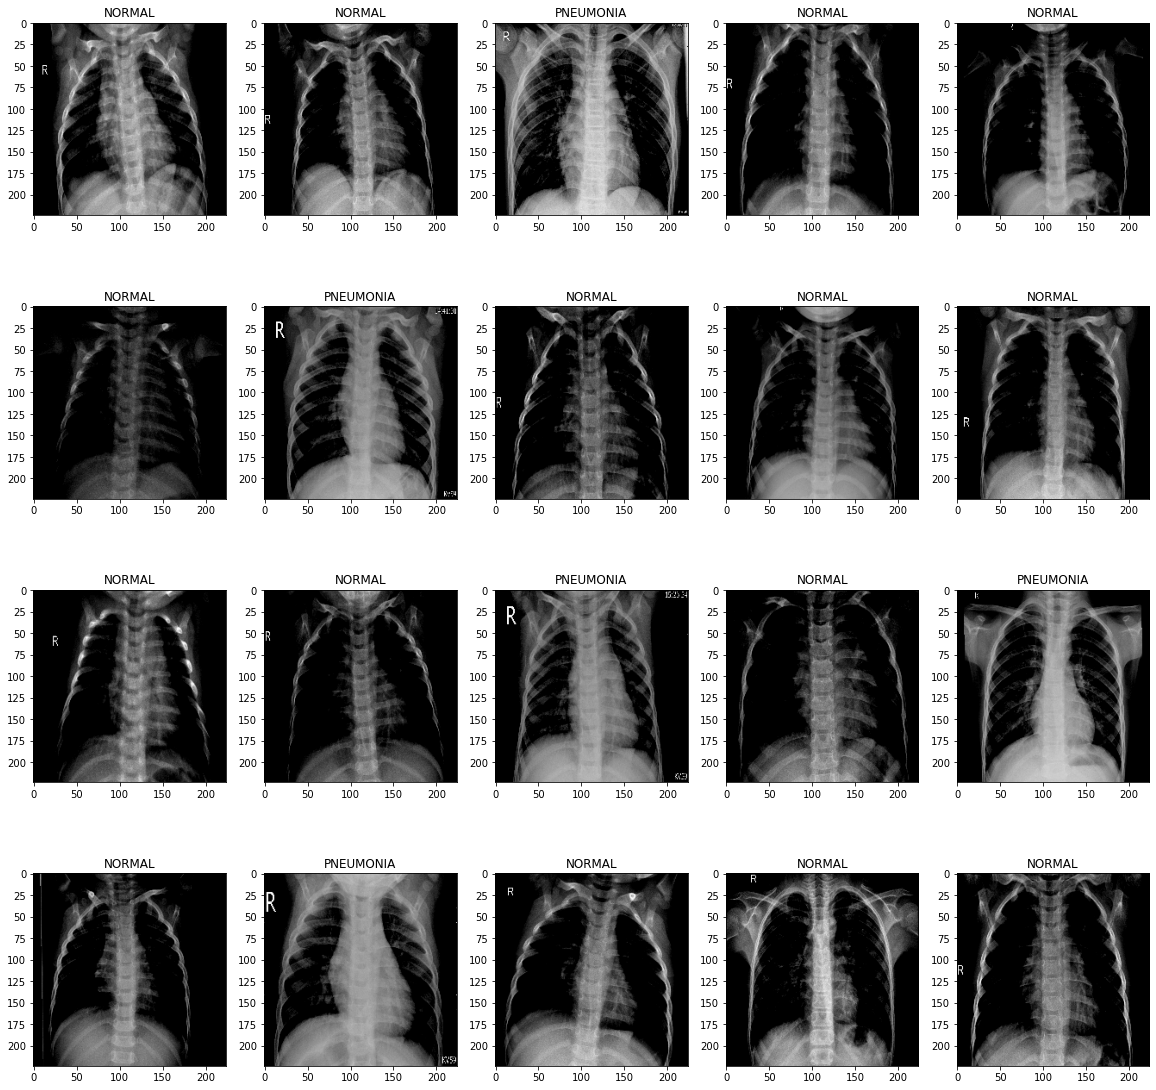

In [33]:
sub = batch_holder[0:20,:]
fig = plt.figure(figsize=(20, 20))
for i,img in enumerate(sub):
    fig.add_subplot(4,5, i+1)
    if result[i][0]==0:
        plt.title("NORMAL") #change for class_names later
    else:
        plt.title("PNEUMONIA")
    plt.imshow(img)
plt.show()

## Performance metrics for Test Data

<Figure size 432x288 with 0 Axes>

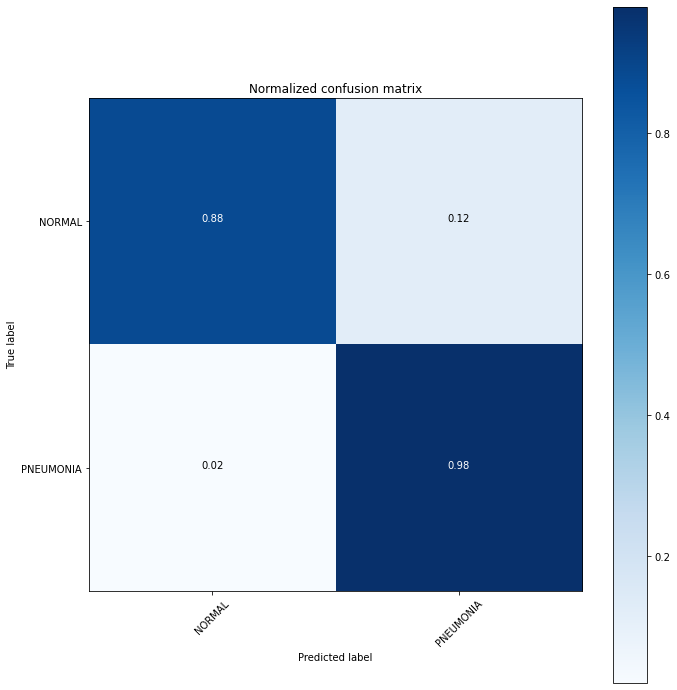

In [34]:
# compute confusion matrix
cnf_matrix = confusion_matrix(ytest, ypred_test)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix') #["NORMAL","PNEUMONIA"]
plt.show()

In [35]:
print("Recall score: "+str(recall_score(ytest, ypred_test)))
print("Precision score: "+str(precision_score(ytest, ypred_test)))
print("F1 score: "+str(f1_score(ytest, ypred_test)))

Recall score: 0.9794871794871794
Precision score: 0.9317073170731708
F1 score: 0.955


--------------------------------
Connect & Save at jovian.ml

In [36]:
!pip install jovian --upgrade --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
import jovian
jovian.commit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>